<a href="https://colab.research.google.com/github/Hami4214/EV-car-price-price-prediction-/blob/main/ev_price_prediction_updated_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import files

# Load dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Cheapestelectriccars-EVDatabase.csv")


# Function to clean numeric columns by removing non-numeric characters


In [3]:
def clean_numeric_column(column):
    return pd.to_numeric(df[column].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

#Function to clean numeric columns by removing non-numeric characters

In [4]:
def clean_numeric_column(column):
    return pd.to_numeric(df[column].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

# Columns to clean

In [5]:
numeric_columns = ["Acceleration", "TopSpeed", "Range", "Efficiency", "FastChargeSpeed", "PriceinGermany", "PriceinUK"]
for col in numeric_columns:
    df[col] = clean_numeric_column(col)

# Drop rows where both PriceinGermany & PriceinUK are missing

In [6]:
df_cleaned = df.dropna(subset=["PriceinGermany", "PriceinUK"], how="all")

# Fill missing FastChargeSpeed values with median

In [7]:
df_cleaned.loc[:, "FastChargeSpeed"] = df_cleaned["FastChargeSpeed"].fillna(df_cleaned["FastChargeSpeed"].median())

# correlation matrix

In [33]:
correlation_matrix = df_cleaned[numeric_columns].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                 Acceleration  TopSpeed     Range  Efficiency  \
Acceleration         1.000000 -0.843316 -0.717680    0.178107   
TopSpeed            -0.843316  1.000000  0.756822   -0.060522   
Range               -0.717680  0.756822  1.000000   -0.085668   
Efficiency           0.178107 -0.060522 -0.085668    1.000000   
FastChargeSpeed     -0.718082  0.762977  0.716136   -0.120906   
PriceinGermany      -0.556683  0.752963  0.625618    0.244630   
PriceinUK           -0.718625  0.869128  0.696603    0.318144   

                 FastChargeSpeed  PriceinGermany  PriceinUK  
Acceleration           -0.718082       -0.556683  -0.718625  
TopSpeed                0.762977        0.752963   0.869128  
Range                   0.716136        0.625618   0.696603  
Efficiency             -0.120906        0.244630   0.318144  
FastChargeSpeed         1.000000        0.600074   0.649608  
PriceinGermany          0.600074        1.000000   0.984412  
PriceinUK               0

 # Correlation Heatmap

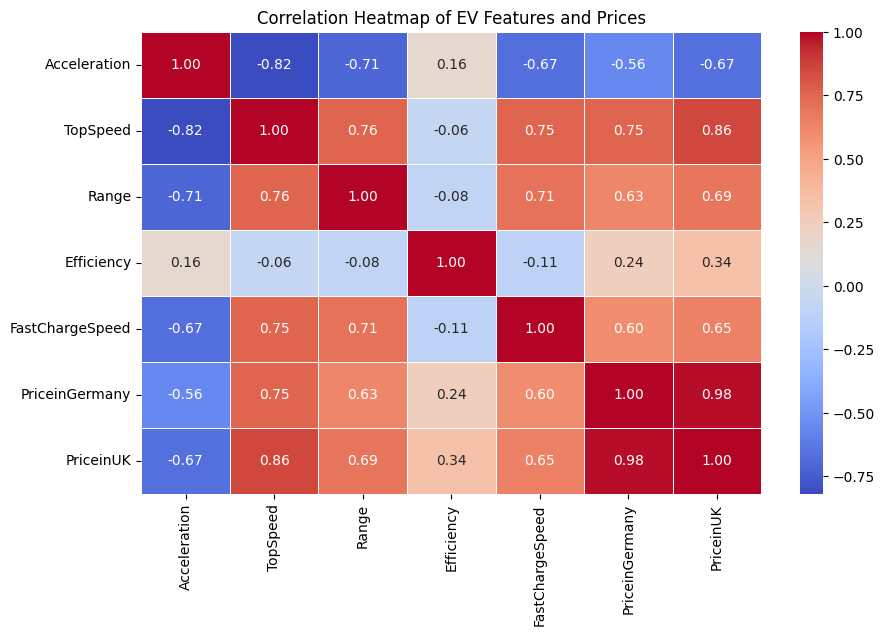

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of EV Features and Prices")
plt.show()


# Define features and targets

In [9]:
features = ["Acceleration", "TopSpeed", "Range", "Efficiency", "FastChargeSpeed"]
target_germany = "PriceinGermany"
target_uk = "PriceinUK"

# Drop rows where PriceinUK is missing for UK model

In [10]:
df_uk = df_cleaned.dropna(subset=[target_uk])

# Split data for Germany

In [11]:
X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(
    df_cleaned[features], df_cleaned[target_germany], test_size=0.2, random_state=42)

# Split data for UK

In [12]:
X_train_uk, X_test_uk, y_train_uk, y_test_uk = train_test_split(
    df_uk[features], df_uk[target_uk], test_size=0.2, random_state=42)

In [13]:
# Drop NaN values from target variables after splitting (test)
y_train_de = y_train_de.dropna()
y_test_de = y_test_de.dropna()

In [14]:
print(y_train_de.isna().sum(), y_test_de.isna().sum())

0 0


# Initialize models

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

#test


In [16]:
print(X_train_de.shape, y_train_de.shape)

(141, 5) (134,)


In [17]:
# Drop rows with NaN values in both X_train_de and y_train_de
train_data_de = pd.concat([X_train_de, y_train_de], axis=1).dropna()
X_train_de = train_data_de[features]  # Extract features again
y_train_de = train_data_de[target_germany]  # Extract target again
print(X_train_de.shape, y_train_de.shape)

(134, 5) (134,)


#test

In [18]:
print(X_test_de.shape, y_test_de.shape)

(36, 5) (34,)


In [19]:
test_data_de = pd.concat([X_test_de, y_test_de], axis=1).dropna()
X_test_de = test_data_de[features]  # Extract features again
y_test_de = test_data_de[target_germany]  # Extract target again
print(X_test_de.shape, y_test_de.shape)

(34, 5) (34,)


# Function to train, predict and evaluate models

In [24]:
def train_and_evaluate(models, X_train, X_test, y_train, y_test, country):
    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred

        results[name] = {
            "R² Score": r2_score(y_test, y_pred),
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred)
        }
        print(f"\n{name} Performance ({country}):")
        print(f"R² Score: {results[name]['R² Score']:.3f}")
        print(f"MAE: {results[name]['MAE']:.2f}")
        print(f"RMSE: {results[name]['RMSE']:.2f}")

    return results, predictions

# Drop NaN values in PriceinGermany before splitting the data

In [25]:
df_cleaned = df_cleaned.dropna(subset=["PriceinGermany"])
print(df_cleaned["PriceinGermany"].isna().sum())

0


In [26]:
print(y_train_de.isna().sum(), y_test_de.isna().sum())

0 0


# Train and evaluate models for Germany

In [27]:
print("\n--- Predicting Prices in Germany ---")
results_germany, predictions_germany = train_and_evaluate(models, X_train_de, X_test_de, y_train_de, y_test_de, "Germany")


--- Predicting Prices in Germany ---

Linear Regression Performance (Germany):
R² Score: 0.476
MAE: 13.48
RMSE: 688.78

Random Forest Performance (Germany):
R² Score: 0.569
MAE: 11.72
RMSE: 566.55

Gradient Boosting Performance (Germany):
R² Score: 0.617
MAE: 12.18
RMSE: 503.94


# Train and evaluate models for UK

In [28]:
print("\n--- Predicting Prices in the UK ---")
results_uk, predictions_uk = train_and_evaluate(models, X_train_uk, X_test_uk, y_train_uk, y_test_uk, "UK")


--- Predicting Prices in the UK ---

Linear Regression Performance (UK):
R² Score: 0.872
MAE: 8.95
RMSE: 182.98

Random Forest Performance (UK):
R² Score: 0.752
MAE: 10.59
RMSE: 355.38

Gradient Boosting Performance (UK):
R² Score: 0.775
MAE: 10.18
RMSE: 322.75


# Predicted Price Comparison (Germany vs. UK)

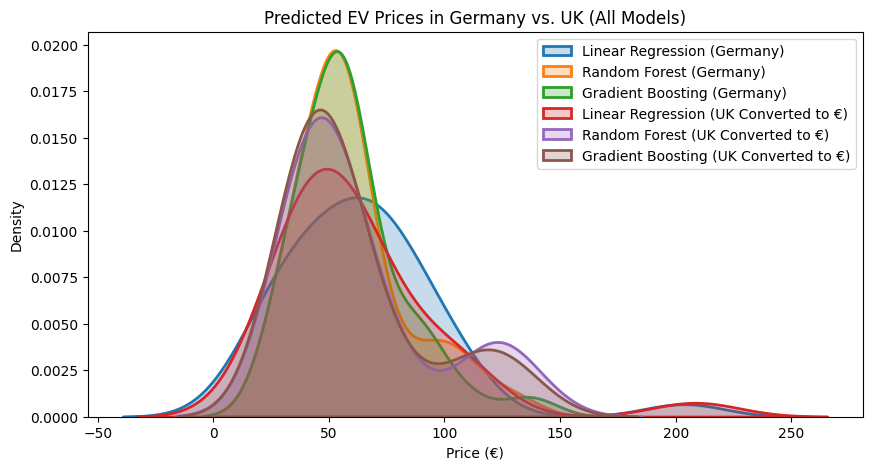

In [29]:
plt.figure(figsize=(10, 5))
for name, preds in predictions_germany.items():
    sns.kdeplot(preds, fill=True, label=f"{name} (Germany)", linewidth=2)
for name, preds in predictions_uk.items():
    sns.kdeplot(preds * 1.17, fill=True, label=f"{name} (UK Converted to €)", linewidth=2)

plt.title("Predicted EV Prices in Germany vs. UK (All Models)")
plt.xlabel("Price (€)")
plt.ylabel("Density")
plt.legend()
plt.show()

# Model Performance Comparison

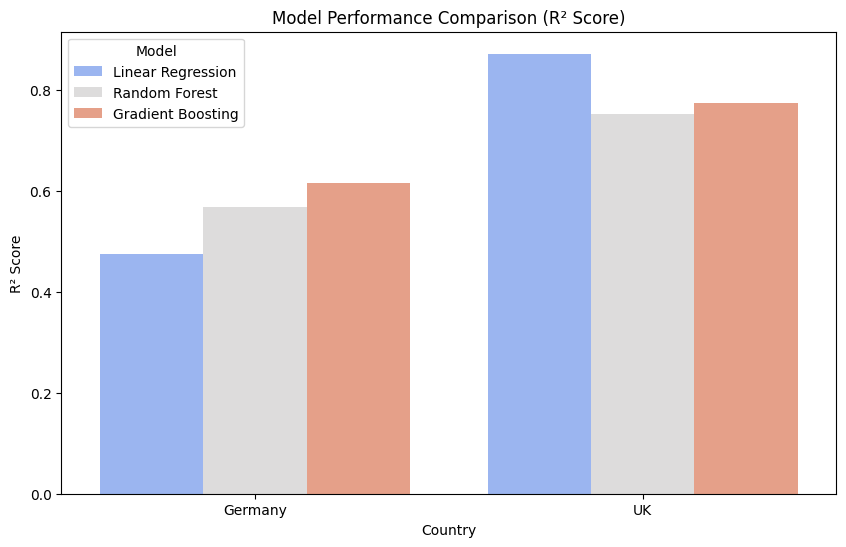

In [30]:
results_df = pd.DataFrame(results_germany).T
results_df["Country"] = "Germany"
results_uk_df = pd.DataFrame(results_uk).T
results_uk_df["Country"] = "UK"
results_combined = pd.concat([results_df, results_uk_df])

plt.figure(figsize=(10, 6))
sns.barplot(x="Country", y="R² Score", hue=results_combined.index, data=results_combined, palette="coolwarm")
plt.title("Model Performance Comparison (R² Score)")
plt.ylabel("R² Score")
plt.legend(title="Model")
plt.show()

# Price Distribution by Country

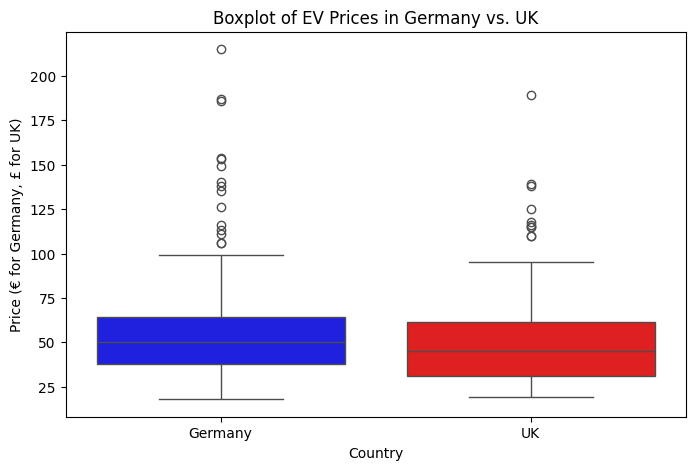

In [32]:
plt.figure(figsize=(8, 5))
df_cleaned_melted = df_cleaned.melt(value_vars=["PriceinGermany", "PriceinUK"], var_name="Country", value_name="Price")
df_cleaned_melted["Country"] = df_cleaned_melted["Country"].replace({"PriceinGermany": "Germany", "PriceinUK": "UK"})

sns.boxplot(x="Country", y="Price", data=df_cleaned_melted,hue="Country",  palette={"Germany": "blue", "UK": "red"})
plt.title("Boxplot of EV Prices in Germany vs. UK")
plt.ylabel("Price (€ for Germany, £ for UK)")
plt.show()